<a href="https://colab.research.google.com/github/Nickqq627/7112029017/blob/main/week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 採用中期融合多模態做回歸任務(預測股票趨勢)
使用LSTM來提取文本序列特徵，能捕捉新聞的時序和語義關係。
使用全連接層處理股價資料，並提取技術指標（如移動平均線、波動率）。

In [36]:
import pandas as pd
import numpy as np

# 載入資料
news_data = pd.read_csv('/content/Combined_News_DJIA(train).csv')
price_data = pd.read_csv('/content/DJIA_table(train).csv')

# 確保日期格式統一
news_data['Date'] = pd.to_datetime(news_data['Date'])
price_data['Date'] = pd.to_datetime(price_data['Date'])

# 合併資料集，使用日期對齊
data = pd.merge(news_data, price_data, on='Date', how='inner')
data.head(3)

<ipython-input-36-8e2489968fc4>:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  price_data['Date'] = pd.to_datetime(price_data['Date'])


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.08984,11759.95996,11388.04004,11734.32031,212830000,11734.32031
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.66992,11867.11035,11675.53027,11782.34961,183190000,11782.34961
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",11781.70020,11782.34961,11601.51953,11642.46973,173590000,11642.46973


In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 合併多條新聞為一個文本
def combine_news(row):
    return " ".join([row[f"Top{i}"] for i in range(1, 26) if pd.notnull(row[f"Top{i}"])])

data['Combined_News'] = data.apply(combine_news, axis=1)

# 文本 Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(data['Combined_News'])
sequences = tokenizer.texts_to_sequences(data['Combined_News'])

# 填充序列
max_length = 128
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [38]:
from sklearn.preprocessing import MinMaxScaler

# 計算技術指標
data['MA_5'] = data['Adj Close'].rolling(window=5).mean()
data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
data['Volatility'] = data['High'] - data['Low']

# 填補缺失值
data.fillna(method='bfill', inplace=True)

# 特徵與標籤
price_features = data[['Open', 'High', 'Low', 'Volume', 'MA_5', 'MA_10', 'Volatility']]
labels = data['Adj Close']

# 特徵正規化
scaler_features = MinMaxScaler()
price_features_scaled = scaler_features.fit_transform(price_features)

scaler_labels = MinMaxScaler()
labels_scaled = scaler_labels.fit_transform(labels.values.reshape(-1, 1))

# --- 時間序列劃分 ---
train_size = int(len(data) * 0.8)
X_train_text = padded_sequences[:train_size]
X_train_price = price_features_scaled[:train_size]
y_train = labels_scaled[:train_size]

X_test_text = padded_sequences[train_size:]
X_test_price = price_features_scaled[train_size:]
y_test = labels_scaled[train_size:]

<ipython-input-38-63bd5a38c58f>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [39]:
from tensorflow.keras import layers, models

# LSTM 模塊處理文本特徵
text_input = layers.Input(shape=(max_length,))
embedding_layer = layers.Embedding(input_dim=10000, output_dim=128, input_length=max_length)(text_input)
lstm_output = layers.LSTM(128, return_sequences=False)(embedding_layer)
lstm_output = layers.Dropout(0.5)(lstm_output)  # 加入Dropout層
text_dense = layers.Dense(64, activation='relu')(lstm_output)
# 處理股價數值特徵
price_input = layers.Input(shape=(price_features.shape[1],))
price_dense = layers.Dense(128, activation='relu')(price_input)
price_dense = layers.Dropout(0.5)(price_dense)  # 加入Dropout層
price_dense = layers.Dense(64, activation='relu')(price_dense)
# 中期融合
merged = layers.Concatenate()([text_dense, price_dense])
merged_dense = layers.Dense(64, activation='relu')(merged)
output = layers.Dense(1)(merged_dense)
# 建立模型
model = models.Model(inputs=[text_input, price_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 128, 128)       │      1,280,000 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 128)            │        131,584 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 128)            │          1,024 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128)            │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128)            │              0 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 64)             │          8,256 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 64)             │          8,256 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 128)            │              0 │ dense_25[0][0],        │
│ (Concatenate)             │                        │                │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 64)             │          8,256 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 1)              │             65 │ dense_28[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,437,441 (5.48 MB)

 Trainable params: 1,437,441 (5.48 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from sklearn.model_selection import train_test_split

# --- 6. 訓練模型 ---
history = model.fit(
    [X_train_text, X_train_price],
    y_train,
    validation_data=([X_test_text, X_test_price], y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - loss: 2.2175e-04 - mae: 0.0100 - val_loss: 0.1593 - val_mae: 0.3983
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - loss: 1.9212e-04 - mae: 0.0101 - val_loss: 0.1689 - val_mae: 0.4102
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - loss: 1.7425e-04 - mae: 0.0094 - val_loss: 0.1623 - val_mae: 0.4021
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step - loss: 1.8830e-04 - mae: 0.0095 - val_loss: 0.1637 - val_mae: 0.4038
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 317ms/step - loss: 2.1254e-04 - mae: 0.0107 - val_loss: 0.1604 - val_mae: 0.3997
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 275ms/step - loss: 2.1193e-04 - mae: 0.0104 - val_loss: 0.1675 - val_mae: 0.4084
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - loss: 1.7727e-04 - mae: 0.0088 - val_loss: 0.1689 - val_mae: 0.4101
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - loss: 1.8626e-04 - mae: 0.0095 - val_loss: 0.1730 - val_mae: 0.4151
Epoch 9/10
47/47

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


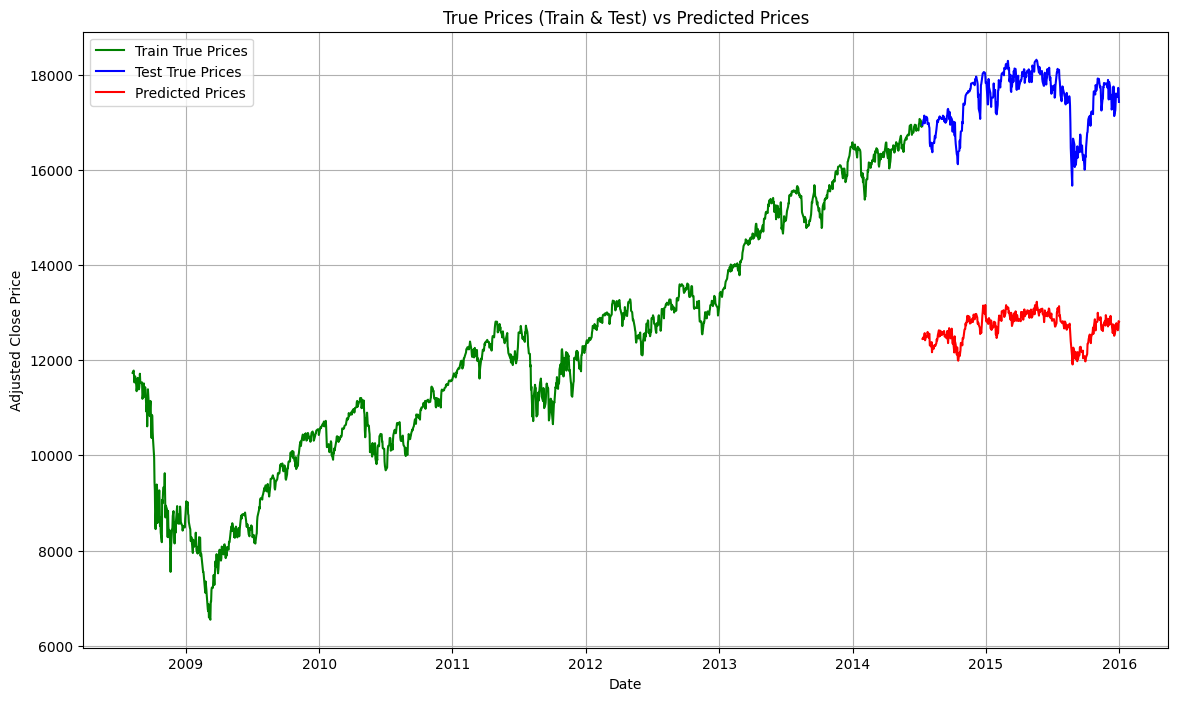

In [43]:
import matplotlib.pyplot as plt
# --- 預測 ---
predictions = model.predict([X_test_text, X_test_price])
predictions = scaler_labels.inverse_transform(predictions)
true_train_values = scaler_labels.inverse_transform(y_train)
true_test_values = scaler_labels.inverse_transform(y_test)

# --- 時間處理 ---
train_dates = data['Date'].iloc[:len(true_train_values)]  # 取出對應訓練資料的日期
test_dates = data['Date'].iloc[len(true_train_values):]   # 取出對應測試資料的日期

# --- 可視化 ---
plt.figure(figsize=(14, 8))

# 繪製訓練資料的真實值
plt.plot(train_dates, true_train_values, label='Train True Prices', color='green')

# 繪製測試資料的真實值
plt.plot(test_dates, true_test_values, label='Test True Prices', color='blue')

# 繪製測試資料的預測值
plt.plot(test_dates, predictions, label='Predicted Prices', color='red')

# 添加標題與標籤
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('True Prices (Train & Test) vs Predicted Prices')
plt.legend()
plt.grid()
plt.show()

### 效果不理想，模型還在優化當中